In [1]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale, RobustScaler
import gc
from skimage.restoration import denoise_wavelet
import scipy.signal as signal
import scipy.stats as stats
import time
import itertools

pd.set_option("max_columns", 200)
pd.set_option("max_rows", 200)
gc.enable()

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def mat_cor(y_true, y_pred):
    assert y_true.shape[0] == y_pred.shape[0]
    
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    numerator = (tp * tn - fp * fn) 
    denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** .5

    return numerator / (denominator + 1e-15)

In [3]:
def read_metadata():
    train_metadata = pd.read_csv('../input/metadata_train.csv')
    test_metadata = pd.read_csv('../input/metadata_test.csv')
    return (train_metadata, test_metadata)

def resample_train():
    data = pq.read_pandas('../input/train.parquet').to_pandas().transpose()
    target = read_metadata()[0]['target'].values
    data['target'] = target
    p_indices = data[data.target == 0].index
    np.random.seed(311)
    random_indices = np.random.choice(p_indices, 1777, replace=False)
    df = pd.concat([data.loc[random_indices][['target']], 
                    data[target == 1][['target']]]).sample(frac=1.0, random_state=311)
    df.to_csv('train_us_target.csv', index=False)
    return df.index


In [4]:
tr_limits = []
start = 0
end = 8712
while True:
    if (start+1000) <= 8712:
        tr_limits.append((start, start+1000))
        start=start+1000
    else:
        tr_limits.append((start, end))
        break
        
ts_limits = []
start = 8712
end = 29049
while True:
    if (start+1000) <= 29049:
        ts_limits.append((start, start+1000))
        start=start+1000
    else:
        ts_limits.append((start, end))
        break

In [5]:
train_metadata, test_metadata = read_metadata()
# resampling_index = resample_train()

In [6]:
def peak_calc(isTrain, filterSignal=True):
    print("peak_calc | start:", time.strftime("%H:%M"))
    peak_counts = {}
    # peak_counts expected values: [[1,3,5,1,6], [4,5,2,2,1], ..]
    
    def f1(df):
        nonlocal peak_counts
        df = df.transpose().values
        
        def filter_sg(sg):
            wv = denoise_wavelet(sg, sigma=None, wavelet='haar', mode='hard', 
                                 wavelet_levels=15, multichannel=False, 
                                 convert2ycbcr=False, method='VisuShrink')
            B, A = signal.butter(N=3, Wn=0.1, output='ba')
            smooth_data = signal.filtfilt(B, A, wv)
            res = (wv - smooth_data) * 100
            return res
        
        if filterSignal:
            df = np.apply_along_axis(filter_sg, 1, df)
        
        print("height", time.strftime("%H:%M"))
        for h in [3, 5, 8, 10, 15, 25, 50, 100]:
            peaks = np.apply_along_axis(signal.find_peaks, 1, df, height=(None, -h))[:, 0]
            num_peaks = [len(x) for x in peaks] 
            if ('height_more_' + str(h)) in peak_counts:
                peak_counts['height_more_' + str(h)].extend(num_peaks)
            else:
                peak_counts['height_more_' + str(h)] = num_peaks
        
        print("threshold", time.strftime("%H:%M"))
        for t in [3, 10, 16, 50]:
            peaks = np.apply_along_axis(signal.find_peaks, 1, df, threshold=(None, -t))[:, 0]
            num_peaks = [len(x) for x in peaks] 
            if ('threshold_more_' + str(t)) in peak_counts:
                peak_counts['threshold_more_' + str(t)].extend(num_peaks)
            else:
                peak_counts['threshold_more_' + str(t)] = num_peaks
                
        print("height and distance", time.strftime("%H:%M"))
        for h, d in itertools.product([3, 5, 8, 10, 15, 25, 50, 100],
                                      [5, 7, 25, 75, 111, 1000, 11111, 100000]):
            peaks = np.apply_along_axis(signal.find_peaks, 1, df, height=(None, -h), distance=d)[:, 0]
            num_peaks = [len(x) for x in peaks] 
            col_name = 'h_bt_' + str(h) + '_dist_bt_' + str(d)
            if (col_name) in peak_counts:
                peak_counts[col_name].extend(num_peaks)
            else:
                peak_counts[col_name] = num_peaks
                
        print("height and width", time.strftime("%H:%M"))
        for h, w in itertools.product([3, 5, 8, 10, 15, 25, 50, 100],
                                      [5, 10, 30, 70, 100, 200, 500]):
            peaks = np.apply_along_axis(signal.find_peaks, 1, df, height=(None, -h), width=w, rel_height=0.4)[:, 0]
            num_peaks = [len(x) for x in peaks] 
            col_name = 'h_bt_' + str(h) + '_w_bt_' + str(w)
            if (col_name) in peak_counts:
                peak_counts[col_name].extend(num_peaks)
            else:
                peak_counts[col_name] = num_peaks
        del peaks
        
        print("max/min widths/proms", time.strftime("%H:%M"))
        max_wdth_pk = []
        std_wdth_pk = []
        skew_wdth_pk = []
        min_wdth_pk = []
        max_prom_pk = []
        std_prom_pk = []
        skew_prom_pk = []
        min_prom_pk = []
        for n in range(df.shape[0]):
            seq = df[n, :]
            peaks, _ = signal.find_peaks(seq, height=(None, -7), threshold=None, distance=None, width=None)
            if len(peaks) == 0:
                pk_proms = [[0]]
                pk_wdths = [0]
            else:
                pk_proms = signal.peak_prominences(seq, peaks, wlen=None)
                pk_wdths = signal.peak_widths(seq, peaks, rel_height=0.4, 
                                              prominence_data=pk_proms, wlen=None)[0]
            max_wdth_pk.append(max(pk_wdths))
            std_wdth_pk.append(np.std(pk_wdths))
            skew_wdth_pk.append(stats.skew(pk_wdths))
            min_wdth_pk.append(min(pk_wdths))
            max_prom_pk.append(max(pk_proms[0]))
            std_prom_pk.append(np.std(pk_proms[0]))
            skew_prom_pk.append(stats.skew(pk_proms[0]))
            min_prom_pk.append(min(pk_proms[0]))
        if ('max_peak_width') in peak_counts:
            peak_counts['max_peak_width'].extend(max_wdth_pk)
        else:
            peak_counts['max_peak_width'] = max_wdth_pk
        if ('std_peak_width') in peak_counts:
            peak_counts['std_peak_width'].extend(std_wdth_pk)
        else:
            peak_counts['std_peak_width'] = std_wdth_pk
        if ('skew_peak_width') in peak_counts:
            peak_counts['skew_peak_width'].extend(skew_wdth_pk)
        else:
            peak_counts['skew_peak_width'] = skew_wdth_pk
        if ('min_peak_width') in peak_counts:
            peak_counts['min_peak_width'].extend(min_wdth_pk)
        else:
            peak_counts['min_peak_width'] = min_wdth_pk
        if ('max_peak_prom') in peak_counts:
            peak_counts['max_peak_prom'].extend(max_prom_pk)
        else:
            peak_counts['max_peak_prom'] = max_prom_pk
        if ('std_peak_prom') in peak_counts:
            peak_counts['std_peak_prom'].extend(std_prom_pk)
        else:
            peak_counts['std_peak_prom'] = std_prom_pk
        if ('skew_peak_prom') in peak_counts:
            peak_counts['skew_peak_prom'].extend(skew_prom_pk)
        else:
            peak_counts['skew_peak_prom'] = skew_prom_pk
        if ('min_peak_prom') in peak_counts:
            peak_counts['min_peak_prom'].extend(min_prom_pk)
        else:
            peak_counts['min_peak_prom'] = min_prom_pk
            
    if isTrain:
        limits = tr_limits
        path = '../input/train.parquet'
        for i, j in limits:
            df = pq.read_pandas(path, columns=[str(i) for i in range(i, j)]).to_pandas()
            f1(df)
    else:
        limits = ts_limits
        path = '../input/test.parquet'
        for i, j in limits:
            df = pq.read_pandas(path, columns=[str(i) for i in range(i, j)]).to_pandas()
            f1(df)
            
    del df; gc.collect()
    print("peak_calc | end:", time.strftime("%H:%M"))
    return peak_counts

In [7]:
def pulse_stats(isTrain):
    print("pulse_stats | start:", time.strftime("%H:%M"))
    sg_max = np.array([], dtype=np.float16)
    sg_min = np.array([], dtype=np.float16)
    sg_mean = np.array([], dtype=np.float16)
    sg_std = np.array([], dtype=np.float16)
    perc1 = np.array([], dtype=np.float16)
    perc3 = np.array([], dtype=np.float16)
    perc5 = np.array([], dtype=np.float16)
    perc7 = np.array([], dtype=np.float16)
    perc9 = np.array([], dtype=np.float16)
    sg_skew = np.array([], dtype=np.float16)
    def f2(df):
        nonlocal sg_max, sg_min, sg_mean, sg_std, perc1, perc3, perc5, perc7, perc9, sg_skew
        df = df.transpose()
        sg_max = np.append(sg_max, df.max(axis=1))
        sg_min = np.append(sg_min, df.min(axis=1))
        sg_mean = np.append(sg_mean, df.mean(axis=1))
        sg_std = np.append(sg_std, df.apply(func=np.std, axis=1, raw=True))
        perc1 = np.append(perc1, df.quantile(q=0.1, axis=1))
        perc3 = np.append(perc3, df.quantile(q=0.3, axis=1))
        perc5 = np.append(perc5, df.quantile(q=0.5, axis=1))
        perc7 = np.append(perc7, df.quantile(q=0.7, axis=1))
        perc9 = np.append(perc9, df.quantile(q=0.9, axis=1))
        sg_skew = np.append(sg_skew, df.apply(func=stats.skew, axis=1, raw=True))

    if isTrain:
        limits = tr_limits
        path = '../input/train.parquet'
        for i, j in limits:
            df = pq.read_pandas(path, columns=[str(i) for i in range(i, j)]).to_pandas()
            f2(df)
    else:
        limits = ts_limits
        path = '../input/test.parquet'
        for i, j in limits:
            df = pq.read_pandas(path, columns=[str(i) for i in range(i, j)]).to_pandas()
            f2(df)
    del df; gc.collect()
    res = pd.DataFrame({'sg_max': sg_max,
                        'sg_min': sg_min,
                        'sg_mean': sg_mean,
                        'sg_std': sg_std,
                        'perc1': perc1,
                        'perc3': perc3,
                        'perc5': perc5,
                        'perc7': perc7,
                        'perc9': perc9,
                        'sg_skew': sg_skew
                       })
    print("pulse_stats | end:", time.strftime("%H:%M"))
    return res

In [8]:
tr = pulse_stats(isTrain=True)
peak_counts = peak_calc(isTrain=True)
for k, v in peak_counts.items():
    tr[k] = v

ts = pulse_stats(isTrain=False)
peak_counts = peak_calc(isTrain=False)
for k, v in peak_counts.items():
    ts[k] = v
    
del peak_counts; gc.collect()

pulse_stats | start: 22:01
pulse_stats | end: 22:22
peak_calc | start: 22:22


/usr/local/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


height 22:23
threshold 22:23
height and distance 22:23
height and width 22:26
max/min widths/proms 22:29
height 22:30
threshold 22:30
height and distance 22:30
height and width 22:33
max/min widths/proms 22:35
height 22:36
threshold 22:37
height and distance 22:37
height and width 22:39
max/min widths/proms 22:42
height 22:43
threshold 22:43
height and distance 22:43
height and width 22:46
max/min widths/proms 22:49
height 22:50
threshold 22:50
height and distance 22:50
height and width 22:53
max/min widths/proms 22:55
height 22:56
threshold 22:57
height and distance 22:57
height and width 23:00
max/min widths/proms 23:02
height 23:03
threshold 23:03
height and distance 23:04
height and width 23:07
max/min widths/proms 23:09
height 23:10
threshold 23:11
height and distance 23:11
height and width 23:14
max/min widths/proms 23:16
height 23:17
threshold 23:17
height and distance 23:17
height and width 23:19
max/min widths/proms 23:21
peak_calc | end: 23:21
pulse_stats | start: 23:21
pulse

616

In [17]:
tr.to_csv('final_v2_tr', index=False)
ts.to_csv('final_v2_ts', index=False)

In [10]:
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return ('matthews', mat_cor(labels, preds), True)


train_data = lgb.Dataset(tr, label=train_metadata['target'])
params={'learning_rate': 0.1, 'objective':'binary', 'metric':'None', 
        'num_leaves': 777, 'verbose': 1, 'random_state':311, 'max_depth': 11,
        'bagging_fraction': 0.7, 'feature_fraction': 1.0, 'min_data_in_leaf': 33,
        'is_unbalance': True}
num_round = 15000
light = lgb.train(params, train_data, num_round, feval=evalerror)
pred = light.predict(ts)
feature_importances = light.feature_importance()
feature_names = ts.columns.values

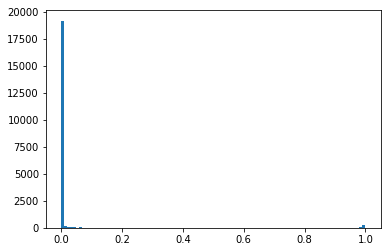

In [11]:
plt.hist(pred, bins=100);

In [12]:
pred = np.where(pred > 0.6, 1, 0)

In [13]:
submission = pd.DataFrame({
        "signal_id": test_metadata['signal_id'],
        "target": pred
})

submission.to_csv('submission.csv', index=False)

Index(['sg_skew', 'sg_std', 'sg_mean', 'sg_max', 'sg_min', 'perc7', 'perc3',
       'perc9', 'perc1', 'height_more_3', 'min_peak_width',
       'h_bt_3_dist_bt_11111', 'min_peak_prom', 'perc5',
       'h_bt_3_dist_bt_100000', 'h_bt_3_dist_bt_1000', 'max_peak_prom',
       'max_peak_width', 'h_bt_3_dist_bt_75', 'h_bt_3_dist_bt_111',
       'height_more_5', 'h_bt_3_dist_bt_5', 'h_bt_3_dist_bt_25',
       'std_peak_prom', 'h_bt_5_dist_bt_100000'],
      dtype='object')


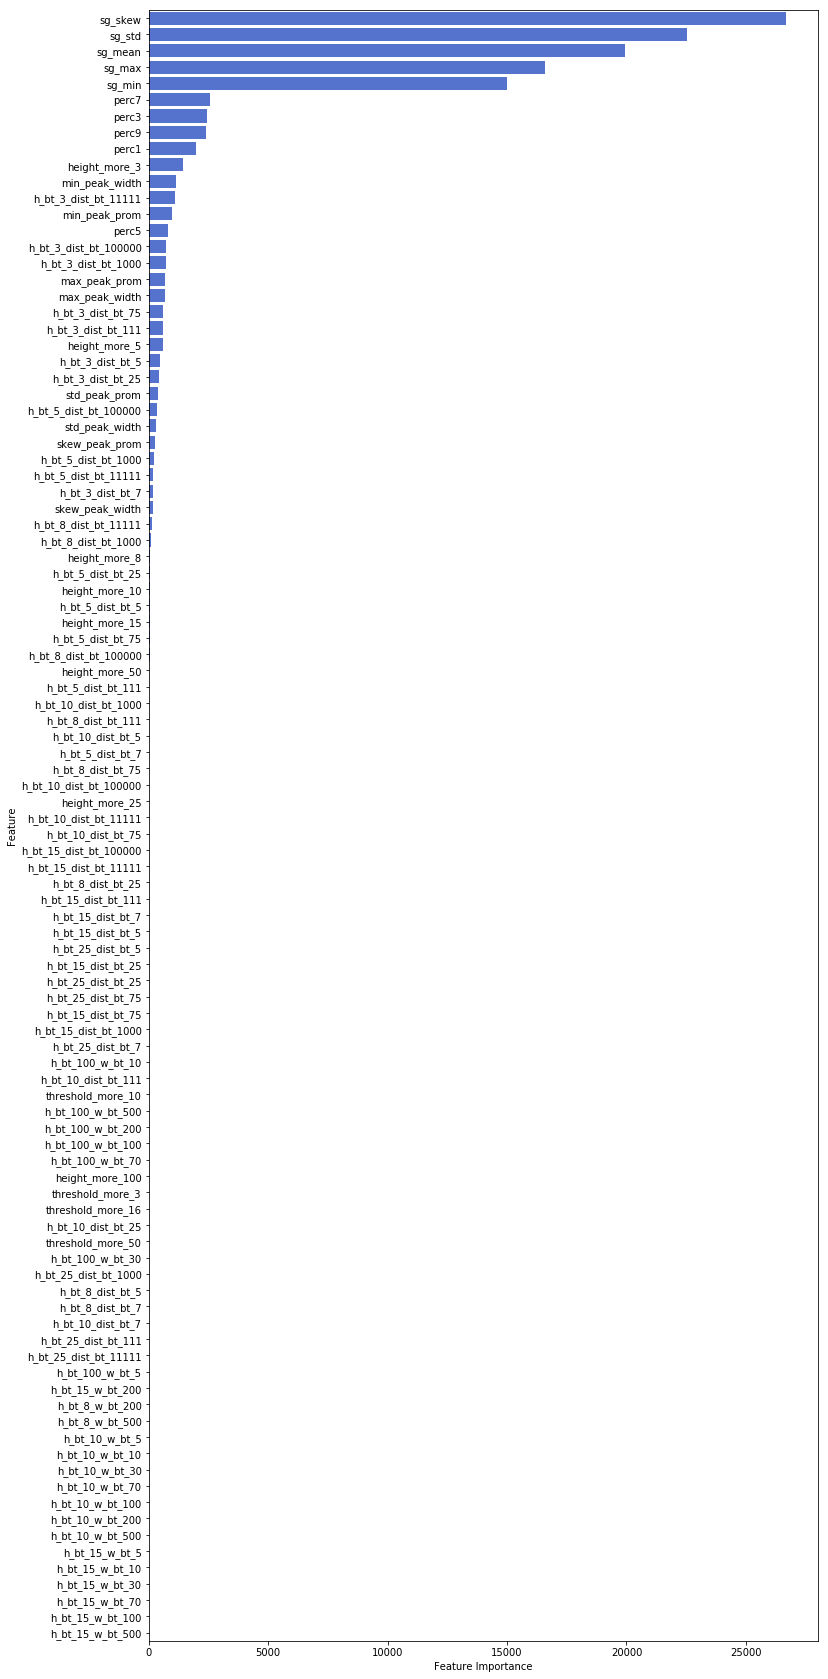

In [14]:
def plot_feat_importances(feature_names, fi, figsize=(12,8), color="royalblue"):
    feature_importances = fi
    feature_importances = pd.Series(
        feature_importances, index=feature_names
        ).sort_values(ascending=False).iloc[:100]
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x=feature_importances, 
                y=feature_importances.index, 
                color=color);
    plt.xlabel('Feature Importance');
    plt.ylabel('Feature');
    print(feature_importances.head(25).index)

plot_feat_importances(feature_names, feature_importances, figsize=(12, 30))

In [15]:
val = tr.copy()
val['target'] = train_metadata['target']
val = val.sample(frac=0.7, replace=True, random_state=2)
tr_pred = light.predict(val.drop('target', axis=1))
tr_pred = np.where(tr_pred > 0.8, 1, 0)
mat_cor(val['target'], tr_pred)

1.0

In [16]:
# pq.read_metadata('../input/test.parquet')

## 